In [1]:
from base_model import util
from base_model.trendNN_value import PricePredictionModel
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
import random
import math
import os
random.seed(10)

# Hyperparameters

In [2]:
seq_len = 128
batch_size = 32 

# Load AAPL Data

In [3]:
ticker = 'AAPL'
baseDataFolder = 'historical_1min'
trainStartDate = '20220101'
trainEndDate = '20220301'
testStartDate = '20220302'
testEndDate = '20220317'
testList, trainList, trainDFList, testDFlist = util.getTrainTestDataList(ticker, 
                          baseDataFolder,
                          trainStartDate=trainStartDate,
                          trainEndDate=trainEndDate,
                          testStartDate=testStartDate,
                          testEndDate=testEndDate,
                          printing=False)

trainDF = pd.concat(trainDFList,ignore_index=True)
testDF = pd.concat(testDFlist,ignore_index=True)
df = pd.concat([trainDF, testDF], ignore_index=True)
train_percent, val_percent = len(trainDF) / (len(trainDF) + len(testDF)) ,  len(testDF) / (len(trainDF) + len(testDF) )
train_index = int(len(df) * train_percent)
val_index = train_index 
test_index = int(train_index + len(testDF)* 0.5)

In [4]:
df

,index,DateTime,Open,Close,High,Low,Volume,Previous_Close,Timestamp,Volume_weighted_avg_price,Number_of_transactions
0,0,2022-01-03 09:30:00-05:00,177.8300,178.0799,178.20,177.7100,1501480.0,177.61,1641220200000,177.8732,19250
1,1,2022-01-03 09:31:00-05:00,178.0500,178.8600,179.03,177.8800,632437.0,177.61,1641220260000,178.6112,10400
2,2,2022-01-03 09:32:00-05:00,178.8400,178.8864,179.31,178.8000,451739.0,177.61,1641220320000,179.0246,6301
3,3,2022-01-03 09:33:00-05:00,178.8900,179.0381,179.11,178.7134,383937.0,177.61,1641220380000,178.9187,3944
4,4,2022-01-03 09:34:00-05:00,179.0200,178.9650,179.24,178.9000,372986.0,177.61,1641220440000,179.0877,3535
...,...,...,...,...,...,...,...,...,...,...,...
20275,385,2022-03-17 15:55:00-04:00,160.1900,160.1900,160.27,160.1000,511408.0,159.59,1647546900000,160.1889,4091
20276,386,2022-03-17 15:56:00-04:00,160.2000,160.2350,160.24,160.1200,315878.0,159.59,1647546960000,160.1853,2728
20277,387,2022-03-17 15:57:00-04:00,160.2400,160.3150,160.33,160.1900,453779.0,159.59,1647547020000,160.2735,3221
20278,388,2022-03-17 15:58:00-04:00,160.3125,160.2650,160.32,160.1900,466874.0,159.59,1647547080000,160.2660,3547


In [5]:
df.iloc[val_index:test_index,:]

,index,DateTime,Open,Close,High,Low,Volume,Previous_Close,Timestamp,Volume_weighted_avg_price,Number_of_transactions
15600,0,2022-03-02 09:30:00-05:00,164.390,164.110,164.6900,164.10,1102396.0,163.18,1646231400000,164.4595,10379
15601,1,2022-03-02 09:31:00-05:00,164.120,164.000,164.1499,163.70,360720.0,163.18,1646231460000,163.9267,4161
15602,2,2022-03-02 09:32:00-05:00,164.010,163.955,164.0200,163.67,257069.0,163.18,1646231520000,163.8087,2898
15603,3,2022-03-02 09:33:00-05:00,163.920,163.800,163.9400,163.54,287893.0,163.18,1646231580000,163.7388,3264
15604,4,2022-03-02 09:34:00-05:00,163.820,163.300,163.8280,163.28,296412.0,163.18,1646231640000,163.4860,3323
...,...,...,...,...,...,...,...,...,...,...,...
17935,385,2022-03-09 15:55:00-05:00,162.810,162.765,162.8700,162.64,444090.0,157.28,1646859300000,162.7404,4393
17936,386,2022-03-09 15:56:00-05:00,162.760,162.630,162.7853,162.57,341352.0,157.28,1646859360000,162.6641,2973
17937,387,2022-03-09 15:57:00-05:00,162.640,162.675,162.7100,162.58,368425.0,157.28,1646859420000,162.6419,3200
17938,388,2022-03-09 15:58:00-05:00,162.675,162.750,162.8000,162.57,595115.0,157.28,1646859480000,162.6975,5112


In [6]:
df.iloc[test_index:,:]

,index,DateTime,Open,Close,High,Low,Volume,Previous_Close,Timestamp,Volume_weighted_avg_price,Number_of_transactions
17940,0,2022-03-10 09:30:00-05:00,160.2000,159.9316,160.3900,159.63,1856045.0,162.98,1646922600000,160.0908,17162
17941,1,2022-03-10 09:31:00-05:00,159.9500,159.8700,160.0600,159.69,506168.0,162.98,1646922660000,159.8741,6045
17942,2,2022-03-10 09:32:00-05:00,159.8800,159.5850,159.8800,159.51,434742.0,162.98,1646922720000,159.6312,4682
17943,3,2022-03-10 09:33:00-05:00,159.6000,159.6090,159.8100,159.51,437323.0,162.98,1646922780000,159.6722,4716
17944,4,2022-03-10 09:34:00-05:00,159.5900,159.3200,159.6199,159.29,444259.0,162.98,1646922840000,159.4398,5186
...,...,...,...,...,...,...,...,...,...,...,...
20275,385,2022-03-17 15:55:00-04:00,160.1900,160.1900,160.2700,160.10,511408.0,159.59,1647546900000,160.1889,4091
20276,386,2022-03-17 15:56:00-04:00,160.2000,160.2350,160.2400,160.12,315878.0,159.59,1647546960000,160.1853,2728
20277,387,2022-03-17 15:57:00-04:00,160.2400,160.3150,160.3300,160.19,453779.0,159.59,1647547020000,160.2735,3221
20278,388,2022-03-17 15:58:00-04:00,160.3125,160.2650,160.3200,160.19,466874.0,159.59,1647547080000,160.2660,3547


# Plot AAPL close prices

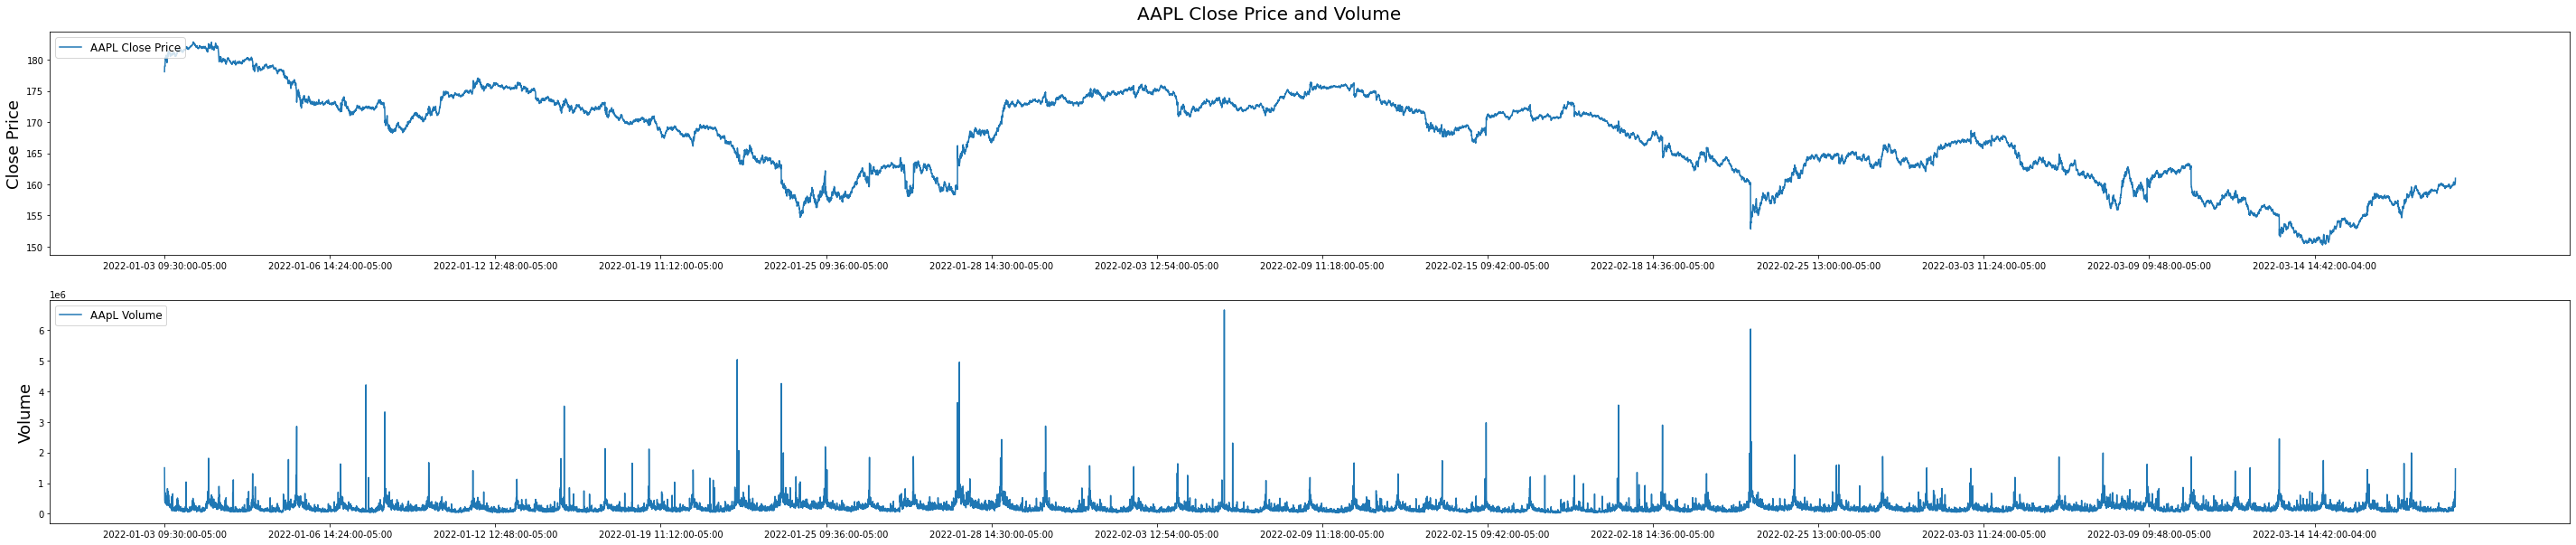

In [7]:
fig = plt.figure(figsize=(50, 10))
st = fig.suptitle("AAPL Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='AAPL Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['DateTime'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='AApL Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['DateTime'].loc[::1464])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

# Normalize data

In [8]:
scaler = MinMaxScaler()
normalizedDF = pd.DataFrame(data=df.loc[:,['Open','Close','High','Low', 'Volume']], columns=['Open','Close','High','Low', 'Volume'])
normalizedDF[['Open','Close','High','Low', 'Volume']] = scaler.fit_transform(df.loc[:,['Open','Close','High','Low', 'Volume']])


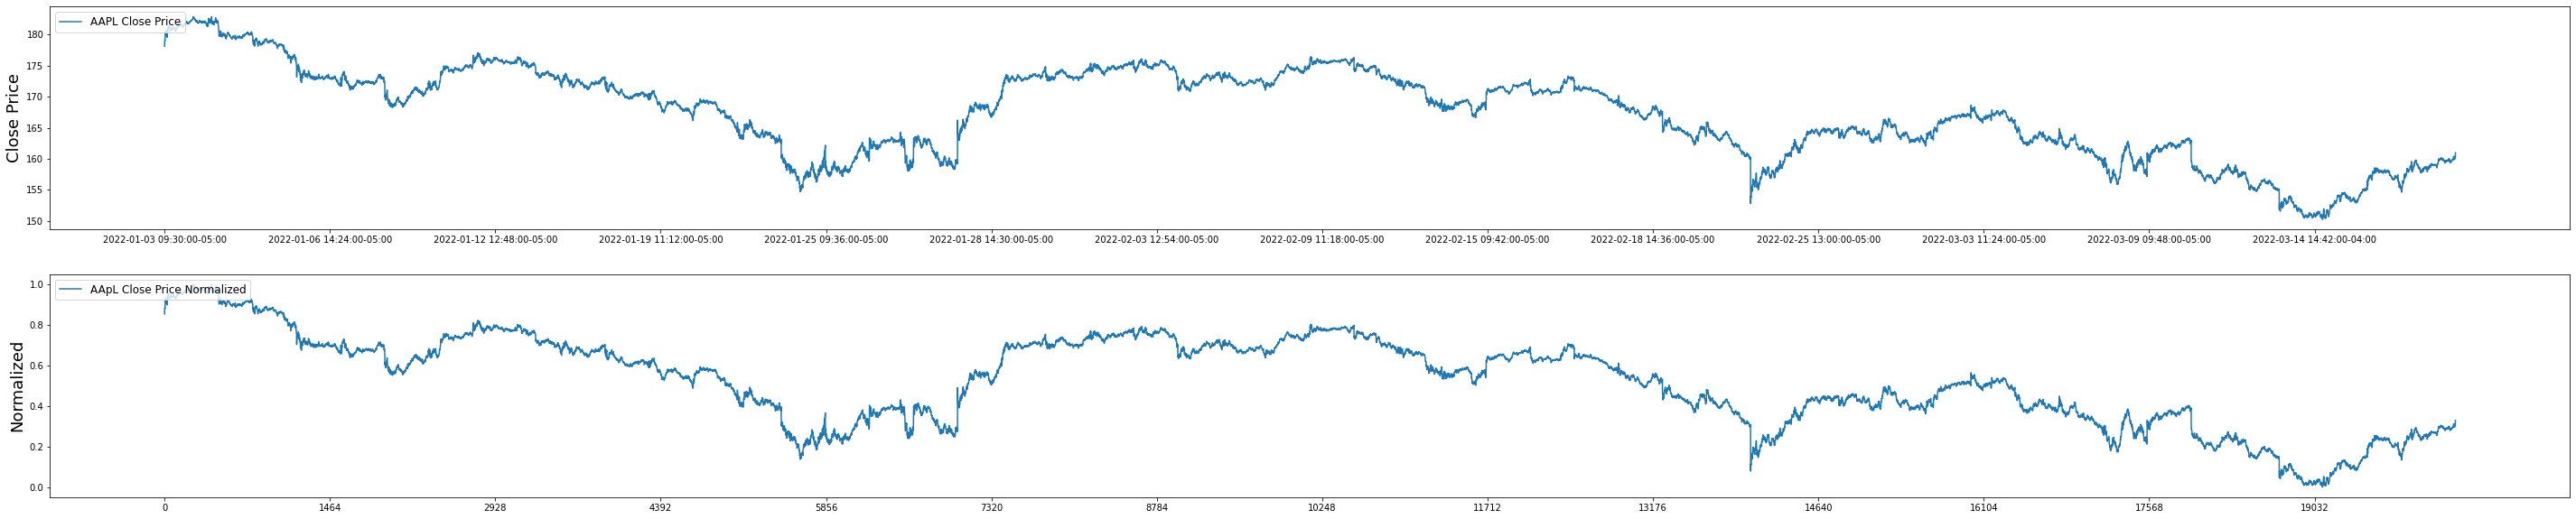

In [9]:
fig2 = plt.figure(figsize=(50, 10))
ax1 = fig2.add_subplot(211)
ax1.plot(df['Close'], label='AAPL Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['DateTime'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig2.add_subplot(212)
ax2.plot(normalizedDF['Close'], label='AApL Close Price Normalized')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['DateTime'].loc[::1464])
ax2.set_ylabel('Normalized', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)


# Create chunks of training, validation and test data

In [10]:
train_data = normalizedDF.iloc[:train_index,:].to_numpy()
val_data = normalizedDF.iloc[val_index:test_index,:].to_numpy()
test_data = normalizedDF.iloc[test_index:,:].to_numpy()

# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 1][i]) #Value of 2nd column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 1][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 1][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)

Training set shape (15472, 128, 5) (15472,)
Validation set shape (2212, 128, 5) (2212,)


In [11]:
torch.FloatTensor(y_val).shape

torch.Size([2212])

# LSTM Base Model

In [12]:
def learn(model,args):
    
    model_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)  
    print(f'Model total parameters: {model_total_params}')
    optimizer = optim.Adam(model.parameters(), lr = args.learning_rate, betas=[0.9, 0.999], weight_decay=args.weight_decay)
    criterion = nn.MSELoss()
    trainFlag = True
    
    import random
    random.seed(10)
    
    optStep = 0
    running_loss = 0
    epoch = 1
    validation_losses = []
    train_losses = []
    Y_val = torch.FloatTensor(y_val).to(device)
    
    for epoch in range(args.total_epoch):
        cursor = 0
        epoch_loss = []
        for i in range(math.ceil(X_train.shape[0]/args.batch_size)):
            cursor = i * args.batch_size
            end_cursor = (i + 1) * args.batch_size 
            # samples = random.sample(range(0, X_train.shape[0]), batch_size)

            # x = X_train[:i, :, :]
            # y = y_train[samples]

            x = X_train[cursor: end_cursor, :, :] 
            y = y_train[cursor: end_cursor]

            y = torch.FloatTensor(y).to(device)
            predictions = model.selectClass(x).squeeze()

            loss = criterion(predictions, y)

            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())
        running_loss = np.average(epoch_loss)
        epoch += 1
        
        if epoch % args.validation_window == 0:
            # validation
            predictions = model.selectClass(X_val).squeeze()
            loss = criterion(predictions, Y_val).squeeze().item()
            
            print(str(epoch) + ' epoch. Train loss is ' + str(running_loss))
            util.printOkBlue(str(epoch) + ' epoch. Validation loss is ' + str(loss))
            if epoch % args.save_window == 0:
                dirPath = f'./base_model/log/{args.model}-{args.ff_dims}'
                if not os.path.isdir(dirPath):
                    os.mkdir(dirPath)
                savePath = f'{dirPath}/policy-{epoch}.para'    
                torch.save(model.state_dict(), savePath)
            train_losses.append(running_loss)
            validation_losses.append(loss)
    
    print(f'training done')
    return train_losses, validation_losses


Model total parameters: 335361
1 epoch. Train loss is 16.132966568595382
1 epoch. Validation loss is 6.235742092132568
2 epoch. Train loss is 11.326825847894229
2 epoch. Validation loss is 0.05622975528240204
3 epoch. Train loss is 0.19233200291487001
3 epoch. Validation loss is 0.5671247243881226
4 epoch. Train loss is 0.36454411699967687
4 epoch. Validation loss is 0.44046130776405334
5 epoch. Train loss is 0.06666393879981085
5 epoch. Validation loss is 0.008338602259755135
6 epoch. Train loss is 1.6143564561424089
6 epoch. Validation loss is 0.04990040138363838
7 epoch. Train loss is 0.13964872650240442
7 epoch. Validation loss is 0.03602679818868637
8 epoch. Train loss is 0.11209408597079339
8 epoch. Validation loss is 0.3701484501361847
9 epoch. Train loss is 0.1657279171008705
9 epoch. Validation loss is 0.17968648672103882
10 epoch. Train loss is 0.9829129721264872
10 epoch. Validation loss is 0.023926150053739548
11 epoch. Train loss is 16.74339995620742
11 epoch. Validation l

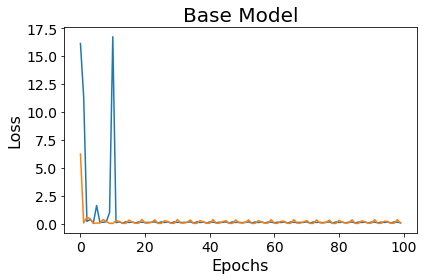

In [13]:

args = util.AttrDict()
args_dict = {
    "model": "lstm",
    "cuda": True,
    "learning_rate": 0.001,
    "batch_size": batch_size,
    "device": 'cuda:0',
    "seq_len": seq_len,
    "ff_dims": 256,
    "dropout": 0.2,
    "weight_decay": 0.001,
    "total_epoch": 100,
    "validation_window": 1,
    "save_window": 1,
}
args.update(args_dict)
device = torch.device("cuda:0")
model = PricePredictionModel(train_data.shape[1],1, args=args).to(device)



t_loss, v_loss = learn(model, args)

def plot_loss(t_loss, v_loss, title):
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker
    plt.figure()
    plt.plot(range(len(t_loss)), t_loss)
    plt.plot(range(len(v_loss)), v_loss)
    plt.title(title, fontsize=20)
    plt.xlabel("Epochs", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
plot_loss(t_loss, v_loss, 'Base Model')   

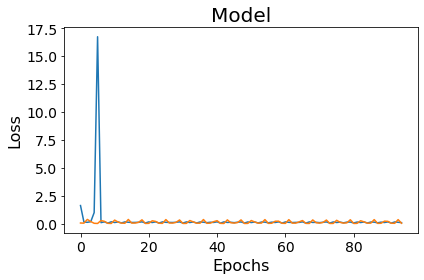

In [14]:
plt.figure()
plt.plot(range(len(t_loss[5:])), t_loss[5:])
plt.plot(range(len(v_loss[5:])), v_loss[5:])
plt.title('Model', fontsize=20)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()